## Análise e Modelagem de Séries Temporais: Previsão de Chamadas de Atendimento ao Cidadão (CSR)

##### Descrição dos dados:

- Acesso: https://data.cincinnati-oh.gov/Efficient-Service-Delivery/Citizen-Service-Request-CSR-Call-Center-Calls/k2qr-ck2v/about_data
- Sobre: Este conjunto de dados contém o registro de todas as chamadas de Solicitação de Atendimento ao Cidadão (CSR) recebidas na central de atendimento da Secretaria de Serviços Públicos (DPS) na cidade de Cincinnati em Ohio, EUA. As Solicitações de Serviço do Cidadão (CSR) oferecem aos residentes de Cincinnati a oportunidade de enviar solicitações de serviço para questões como coleta de móveis, grama alta e reparos de buracos.

##### Entregáveis:

1. Carregamento, Preparação e Limpeza de Dados
    - Visualização inicial
    - Sumarizar dados de quantidade de ligações (inicialmente em meses, Ex: jun/21 30)
    - Verificar dados faltantes

2. Análise Descritiva
    - Decribe dos dados para analisar principais estatísticas
    - Drigrama de Caixa (Entender presença de outliers e tratar)

    Entendendo Distribuição
    - Plot dos dados em um histograma (Entender distribuição dos dados)
    - Q-Q Plot
    
    Entendendo a Série - Verificando Estacionariade
    - Plot gráfico série temporal para avaliar visualmente se há tendência, sazonalidade...
    - Plot gráfico com decomposição série temporal
    - Aplicar log e/ou diferenciação dos dados para estabilizar a série (diferenciação sazonal caso haja, tentar possibilidades)
    - Plot da série após isso, verificar visualmente se há estacionariadade 
    - Describe dos dados para avaliar se a média tende a 0
    - Plot Q-Q Plot

    Gráficos de Autocorrelação
    - Plot Autocorrelação (Verificar tabela com comportamentos)
    - Plot Autocorrelação Parcial (Verificar tabela com comportamentos)
    - Inspeção Visual sobre quais candidados para modelagem ARIMA
    
3. Previsão com ARIMA
    - Divisão dados em Treino, Teste

    Treino
    - Aplicação ARIMA (aplicar nos dados não diferenciados)
        - Avaliar valores de AIC (menor melhor)
        - Análises de resíduos (plot resíduos ARIMA, Q-Q Plot, ACF (valores dentro da faixa de 95%), ACFP (valores dentro da faixa de 95%))
    - Plot da série com ajuste
    
    Teste
    - Predict da base utilizando o Teste
    - Plot Serie com a previsão
    - Calcular MAPE e RMSE (verificar para voltar medida da série)

4. Previsão com Aprendizagem de Máquina (Random Florest)

    - Divisão dados em Treino, Teste
    - Previsões
    - Aplicação em Teste
    - Plot Séries com Previsões
    - Calcular MAPE e RMSE

5. Conclusão

##### Importação Bibliotecas

In [43]:
# Importação, manipulação e análises gráficas com dados
import os
from google.cloud import bigquery
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Previsões com modelagem ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose # Trabalhar com decomposição componentes Séries Temporais
from statsmodels.graphics.tsaplots import plot_acf # Plot da função de autocorrelação
from statsmodels.graphics.tsaplots import plot_pacf # Plot da função de autocorrelação parcial
import statsmodels.api as sm # Plot do gráfico Q-QPlot
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats # Plot do gráfico Q-QPlot (Ajuda para verificar se os dados aproximam de uma distribuição normal visualmente)
from statsmodels.tsa.stattools import adfuller

# Previsões com Random Forest e cálculo métricas
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

##### 1. Carregamento, Preparação e Limpeza de Dados

Informações sobre conjunto de dados bruto

In [2]:
# Definir variável de ambiente
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "../../data/credentials_bigquery.json" 

# Criar cliente de conexão com banco de dados BigQuery
client = bigquery.Client()

In [3]:
# Carregamento da query da BigQuery tabela completa
query_job = client.query("""
SELECT
     *
FROM `project-tcc-434118.SILVER_ATD_CSR.tb_interacao_receptivo` TABLESAMPLE SYSTEM (0.1 PERCENT)
""")

# Convertendo objeto de consulta BigQuery em um dataframe pandas
df = query_job.to_dataframe()

In [5]:
df.head(5)

,registroId,agenteDispId,dtChamada,acaoChamadaId,acaoMotivoChamadaId,chamadaId,dtEncerramentoConnHora,dtEntradaFilaHora,numSequencial,servicoId,...,dtInicioPreVisualizacao,dtFimPreVisualizacao,dtResposta,tempoRespostaSeg,tempoConversaSeg,tempoEncerramentoSeg,nivelServico,statusAbandono,statusChamada,dtProcessamento
0,93093223,-1,2014-09-12,3,2,3,2014-09-12 05:04:41,NaT,9309322,106,...,NaT,NaT,NaT,0,238,0,0,0,1,2024-09-10
1,11733172492,-1,2015-06-23,3,2,492,2015-06-23 05:57:55,NaT,11733172,106,...,NaT,NaT,NaT,0,82,0,0,0,1,2024-09-10
2,930934214,-1,2014-09-12,3,2,14,2014-09-12 05:03:56,NaT,9309342,106,...,NaT,NaT,NaT,0,43,0,0,0,1,2024-09-10
3,93083687,-1,2014-09-12,3,2,7,2014-09-12 04:58:43,NaT,9308368,106,...,NaT,NaT,NaT,0,125,0,0,0,1,2024-09-10
4,289477294486,<NA>,2019-11-15,21,4,4486,NaT,2019-11-14 20:25:34,28947729,106,...,NaT,NaT,NaT,23,0,0,1,0,0,2024-09-10


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841391 entries, 0 to 841390
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   registroId               841391 non-null  Int64         
 1   agenteDispId             634043 non-null  Int64         
 2   dtChamada                841391 non-null  dbdate        
 3   acaoChamadaId            841391 non-null  Int64         
 4   acaoMotivoChamadaId      841391 non-null  Int64         
 5   chamadaId                841391 non-null  Int64         
 6   dtEncerramentoConnHora   634054 non-null  datetime64[us]
 7   dtEntradaFilaHora        840325 non-null  datetime64[us]
 8   numSequencial            841391 non-null  Int64         
 9   servicoId                841391 non-null  Int64         
 10  estacao                  634020 non-null  Int64         
 11  grupoTrabalhoId          841391 non-null  Int64         
 12  dtTerminoEncerra

In [32]:
df.shape

(841391, 23)

Base Segmentada: Quantidade de Chamadas por meses

In [17]:
query_job = client.query("""
SELECT
     CAST(CONCAT(EXTRACT(YEAR FROM dtChamada), '-', EXTRACT(MONTH FROM dtChamada), '-1') AS DATE) AS mesAno
    ,COUNT(1) AS qtdChamada

FROM `project-tcc-434118.SILVER_ATD_CSR.tb_interacao_receptivo`


GROUP BY
    CAST(CONCAT(EXTRACT(YEAR FROM dtChamada), '-', EXTRACT(MONTH FROM dtChamada), '-1') AS DATE)        
""")

df_meses = query_job.to_dataframe()

df_meses['mesAno'] = pd.to_datetime(df_meses['mesAno'], format="%m-%d-%Y")
df_meses.sort_values(by=['mesAno'], ascending=True, inplace=True)
df_meses.reset_index(inplace=True)

df_meses = df_meses[['mesAno', 'qtdChamada']]
df_meses

,mesAno,qtdChamada
0,2014-04-01,44
1,2014-05-01,13
2,2014-06-01,9
3,2014-07-01,480
4,2014-08-01,8345
...,...,...
110,2023-06-01,19
111,2023-07-01,28
112,2023-08-01,27
113,2023-09-01,25


In [18]:
# Verificando se há meses sem volumetria

dt_min        = df_meses['mesAno'].min()
dt_max        = df_meses['mesAno'].max()
qtd_mes_prev  = np.round(((dt_max - dt_min).days + 30)*12/(365), 0)
qtd_mes_base  = len(df_meses)

print(f'''Data Mínima: {dt_min}
Data Máxima: {dt_max}
Quantidade Meses Previsto Intervalo: {qtd_mes_prev} 
Quantidade Meses na Base: {qtd_mes_base}
''')

if qtd_mes_base == qtd_mes_prev:
    print("Base de dados sem meses faltantes")
else:
    print(f"Base com meses faltantes, com diferença entre previsto e real de {qtd_mes_prev - qtd_mes_base}")

Data Mínima: 2014-04-01 00:00:00
Data Máxima: 2023-10-01 00:00:00
Quantidade Meses Previsto Intervalo: 115.0 
Quantidade Meses na Base: 115

Base de dados sem meses faltantes


In [7]:
df_meses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   mesAno      115 non-null    datetime64[ns]
 1   qtdChamada  115 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 2.0 KB


##### 2. Análise Descritiva

Algumas métricas estatísticas dos dados

In [19]:
df_meses.describe()

,mesAno,qtdChamada
count,115,115.0
mean,2018-12-31 08:58:26.086956544,7316.443478
min,2014-04-01 00:00:00,9.0
25%,2016-08-16 12:00:00,6234.5
50%,2019-01-01 00:00:00,8085.0
75%,2021-05-16 12:00:00,9416.5
max,2023-10-01 00:00:00,14758.0
std,NaN,3519.78547


Verificando volumetria ao longo do tempo

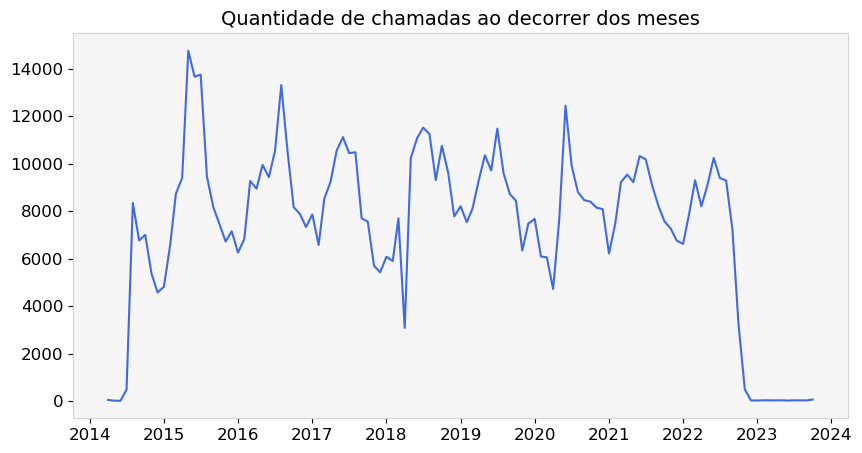

In [30]:
def graf_line(x, y, title=""):
    
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(
        x, 
        y, 
        linewidth=1.5,
        color='#4169E1'
    )
    ax.set_title(title, fontsize=14)
    #ax.set_xlabel('Data', fontsize=14)
    #ax.grid(True, linestyle='--', alpha=1, color='gray')
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

graf_line(df_meses['mesAno'], df_meses['qtdChamada'], "Quantidade de chamadas ao decorrer dos meses")

##### Investigando Outliers
- A partir de valores de média, mínimo e máximo, provavelmente há meses com volumetrias atípicas

Histograma

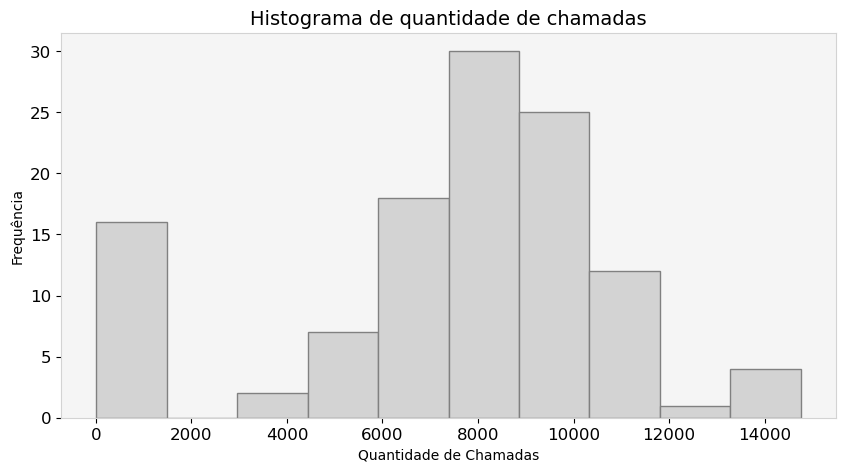

In [31]:
def graf_histograma(data, title=""):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Criando o histograma
    ax.hist(data, color='lightgrey', edgecolor='grey')

    # Personalizando o gráfico
    ax.set_xlabel("Quantidade de Chamadas")
    ax.set_ylabel("Frequência")
    ax.set_title(title, fontsize=14)
    ax.set_facecolor('whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Ajustando as bordas do gráfico
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

    # Exibindo o gráfico
    plt.show()

graf_histograma(df_meses['qtdChamada'], "Histograma de quantidade de chamadas")

BoxPlot

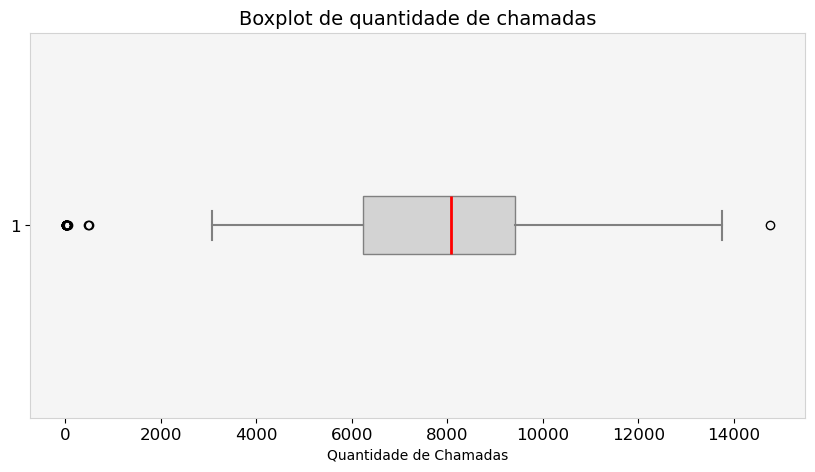

In [32]:
def graf_box_plot(data, title=""):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.boxplot(data, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightGrey', color='gray'),
            whiskerprops=dict(color='grey', linewidth=1.5),
            capprops=dict(color='grey', linewidth=1.5),
            medianprops=dict(color='red', linewidth=2))

    # Personalização o gráfico
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Quantidade de Chamadas")
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda


    # Exibindo o gráfico
    plt.show()

graf_box_plot(df_meses['qtdChamada'], "Boxplot de quantidade de chamadas")

A partir dos gráficos de caixa e histogramas e métricas estatísticas mostradas, é possível observar alguns outliers, visto que há valores de mínimo e máximo bem distantes da média e fora do Intervalo IQR (diferença entre quartis: Q3 - Q1) conforme visualização do gráfico box plot. Observa no gráfico histograma que a ditribuição dos dados apróxima-se a uma distribuição normal, isso é bom indicativo para ajustamento dos dados no futuro. Abaixo iremos verificar os meses que aparentam ser outliers e adotar ponderações para continuar as análises.

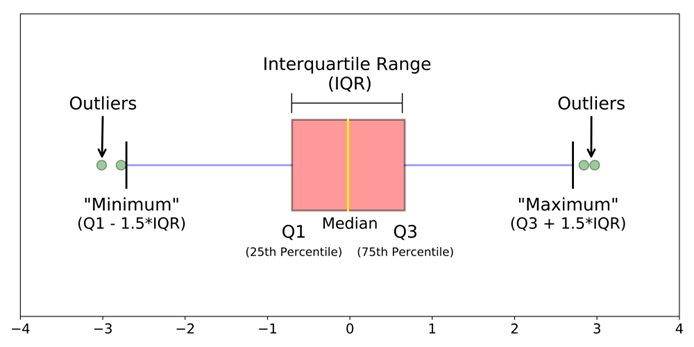

Fonte: https://www.laboneconsultoria.com.br/o-que-e-boxplot/


Fonte adicional: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

In [24]:
# Calculando estatísticas

q1      = df_meses['qtdChamada'].quantile(0.25)
q3      = df_meses['qtdChamada'].quantile(0.75)
mediana  = df_meses['qtdChamada'].median()

iqr_score = q3 - q1
inferior = q1 - (1.5*iqr_score)
superior = q3 + (1.5*iqr_score)

print(f'Mediana: {mediana}\nQ1: {q1}\nQ3: {q3}\nO IQR Score calculado é: {iqr_score}\nLimite inferior = {inferior}\nLimite Superior = {superior}')

# Mostrando linhas consideradas outiliers, que estão fora IQR

df_out = df_meses[(df_meses['qtdChamada'] <= inferior) | (df_meses['qtdChamada'] >= superior)]

display(df_out)

Mediana: 8085.0
Q1: 6234.5
Q3: 9416.5
O IQR Score calculado é: 3182.0
Limite inferior = 1461.5
Limite Superior = 14189.5


,mesAno,qtdChamada
0,2014-04-01,44
1,2014-05-01,13
2,2014-06-01,9
3,2014-07-01,480
13,2015-05-01,14758
103,2022-11-01,493
104,2022-12-01,26
105,2023-01-01,19
106,2023-02-01,30
107,2023-03-01,29


Observando os valores considerados outliers, é possível observar que a maioria trata-se de valores iniciais ou finais do conjunto de dados, com exceção do registro 13, do mês de maio de 2015. Para previsões, optaremos por excluir os dados considerados outliers, mantendo apenas o registro 13. Esses valores podem ser devido a algum problema de ingestão, visto que estão muito afastados da mediana histórica, e estes, não vão atrapalhar para a futura previsão. No entanto, para o registro 13 iremos plotar uma visualização de 2015 para entender melhor o cenário de volume neste ano.

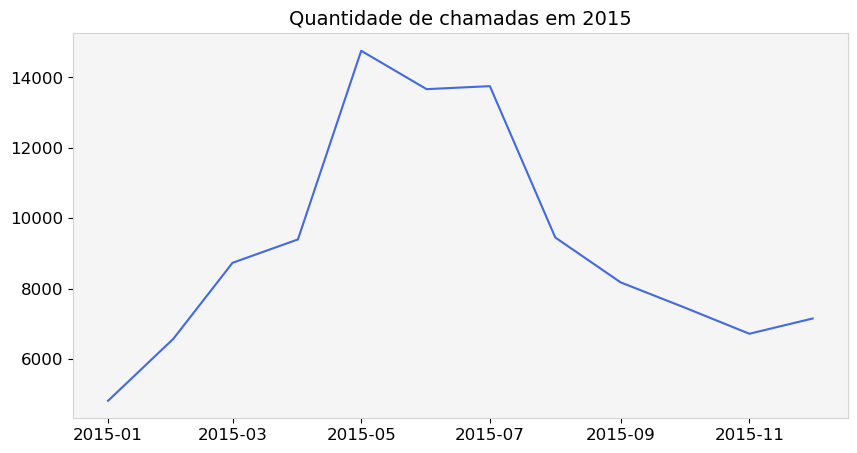

In [33]:
df_meses_15 = df_meses[df_meses['mesAno'].dt.year == 2015]
graf_line(df_meses_15['mesAno'], df_meses_15['qtdChamada'], "Quantidade de chamadas em 2015")

Para o ano de 2015, observa-se que foi uma ano com maior volumetria comparados com os demais, acredita-se ser algo que pode acontecer a depender de variáveis externas, como eventos, economia e entre outros fatores. Por isso, optaremos em exlcuir apenas os extremos mínimos e máximos, seguindo as análises com o período de 08/2014 a 08/2022, será desconsiderado os dois últimos meses de 2022 para que tenhamos um intevalo simétrico de 8 anos completo

Excluíndo Outliers

,mesAno,qtdChamada
4,2014-08-01,8345
5,2014-09-01,6766
6,2014-10-01,7000
7,2014-11-01,5368
8,2014-12-01,4570
...,...,...
96,2022-04-01,8207
97,2022-05-01,9093
98,2022-06-01,10242
99,2022-07-01,9401


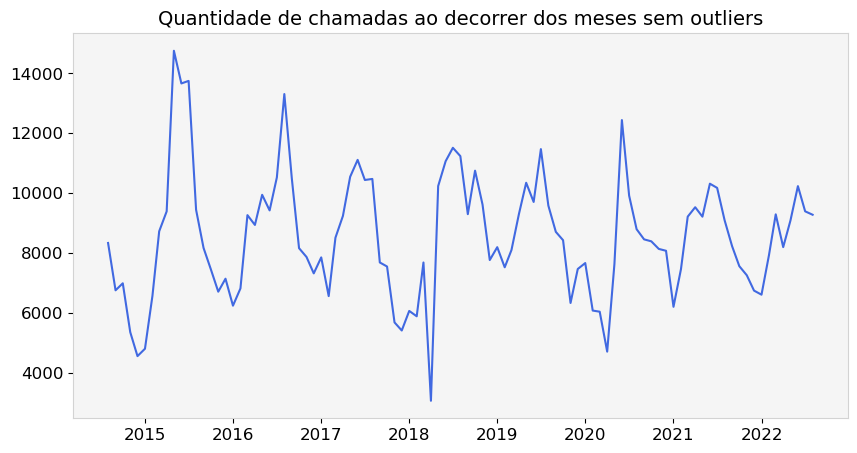

In [34]:
df_meses_v1 = df_meses[~(df_meses['qtdChamada'] <= inferior)]
df_meses_v1 = df_meses_v1[(df_meses_v1['mesAno'] <= '2022-08-01')]

display(df_meses_v1)
graf_line(df_meses_v1['mesAno'], df_meses_v1['qtdChamada'], "Quantidade de chamadas ao decorrer dos meses sem outliers")


Decomposição da série

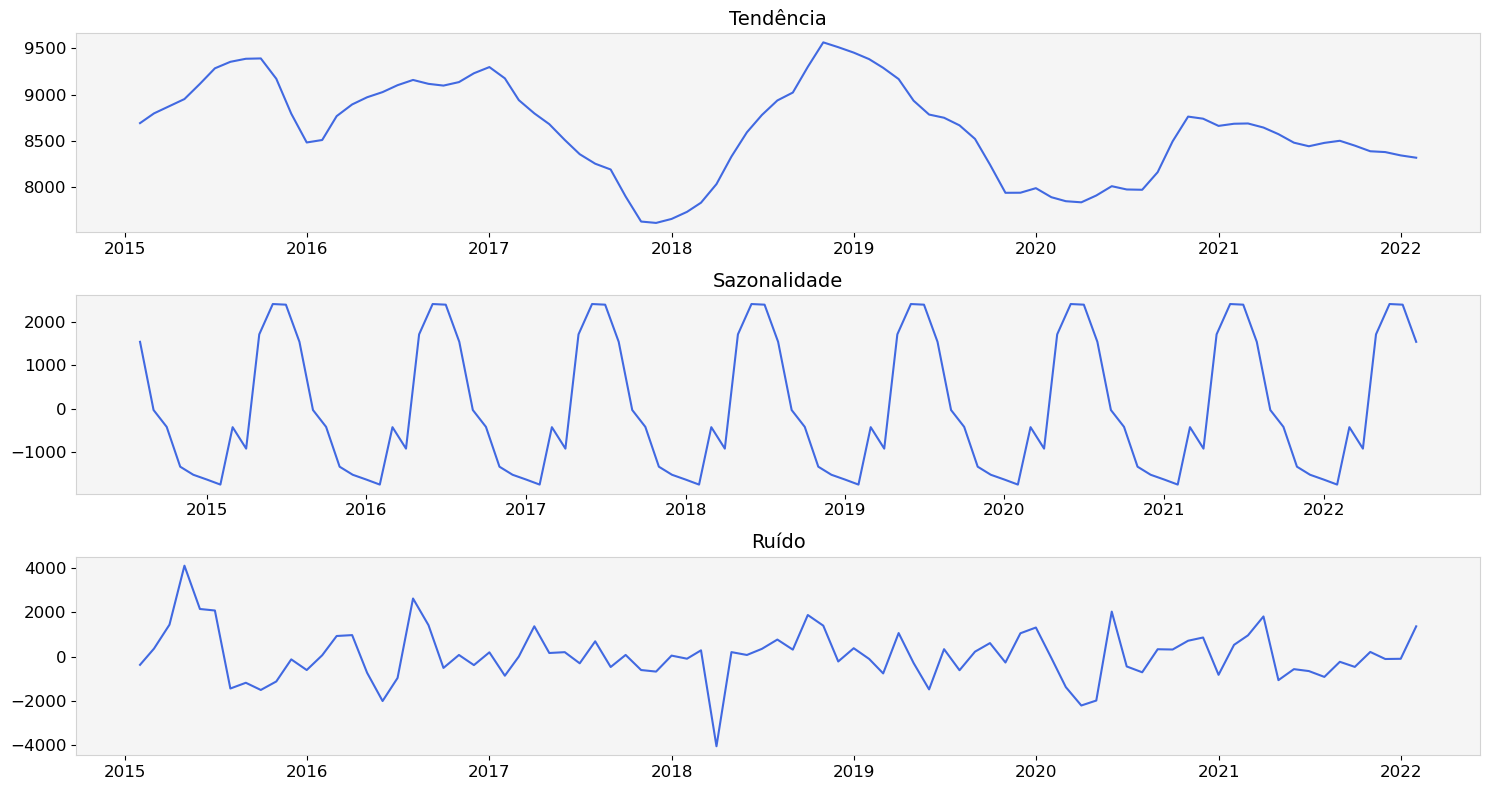

In [35]:
def plot_ax(eixo_x, y, ax, title="", color_line="", label_legend=""):
    
    if color_line == "": color_line='#4169E1'

    ax.plot(
        eixo_x, 
        y, 
        linewidth=1.5,
        color=color_line,
        label=label_legend
    )
    ax.set_title(title, fontsize=14)
    #ax.set_xlabel('Data', fontsize=14)
    #ax.grid(True, linestyle='--', alpha=1, color='gray')
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

def graf_decomp(eixo_x, data):    
    
    result = seasonal_decompose(data, model='additive', period=12)

    # Plotar em tamanho maior
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

    plot_ax(eixo_x, result.trend, ax1, "Tendência")
    plot_ax(eixo_x, result.seasonal, ax2, "Sazonalidade")
    plot_ax(eixo_x, result.resid, ax3, "Ruído")

    plt.tight_layout()
    plt.show()

graf_decomp(df_meses_v1['mesAno'], df_meses_v1['qtdChamada'])

Entendo a distribuição dos dados

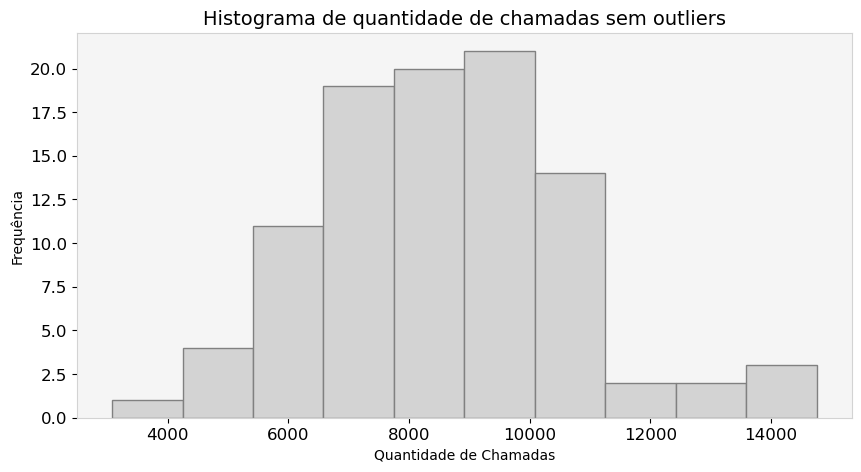

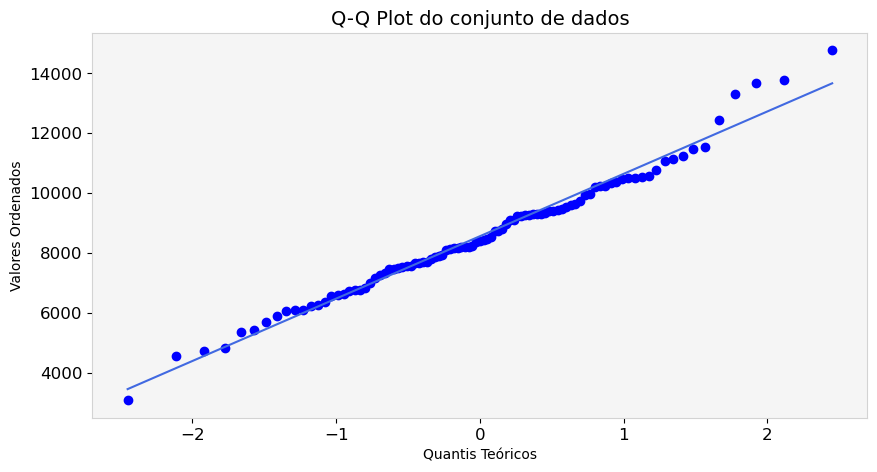

In [36]:
def graf_qq(data, title=""):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Cria o Q-Q plot
    stats.probplot(data, dist="norm", plot=ax)
    
    # Personalizações do gráfico
    ax.get_lines()[1].set_color('#4169E1')  # Linha de ajuste
    ax.get_lines()[1].set_linewidth(1.5)
    
    ax.set_title(title, fontsize=14)
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Quantis Teóricos')
    ax.set_ylabel('Valores Ordenados')

    # Personaliza bordas
    ax.spines['top'].set_color('lightgray')
    ax.spines['right'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')
    ax.spines['left'].set_color('lightgray')
    
    plt.show()

graf_histograma(df_meses_v1['qtdChamada'], "Histograma de quantidade de chamadas sem outliers")
graf_qq(df_meses_v1['qtdChamada'], "Q-Q Plot do conjunto de dados")

A partir dos dois gráficos, histograma e Q-Q Plot podemos considerar que a distribuição dos dados seguem a uma aproximação normal, como isso não há necessidade de transformação dos dados através um Log ou diferenciação, pois com essa caractéristicas podemos considerar o conjunto estacionário. No trabalho em questão não utilizaremos testes para verificar a estacionariedade, porém pode ser um ponto de melhoria para análises futuras.

Gráficos de Autocorrelação

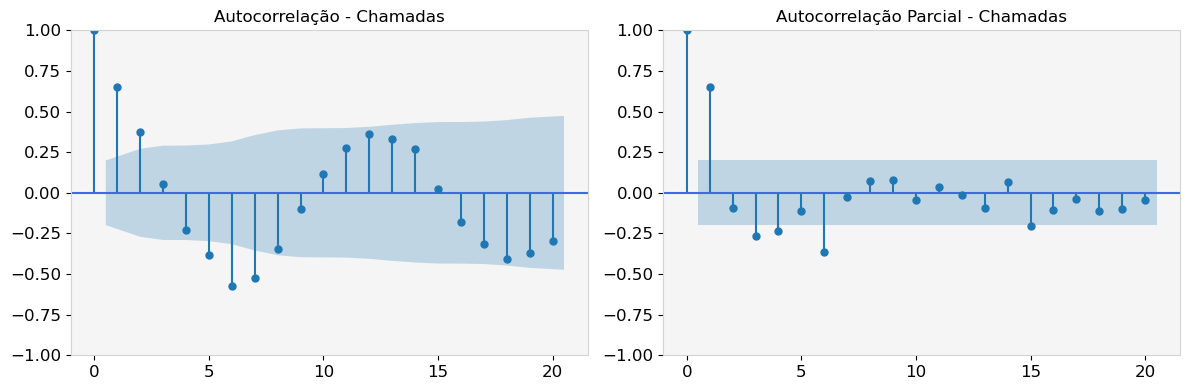

In [37]:
def graf_autocorr(data, title=""):

    # Cria uma figura com 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Ajuste o figsize conforme necessário

    # Plota a autocorrelação
    plot_acf(data.dropna(), lags=20, alpha=0.05, ax=axes[0])
    axes[0].set_title(f"Autocorrelação - {title}")

    # Plota a autocorrelação parcial
    plot_pacf(data.dropna(), lags=20, alpha=0.05, ax=axes[1])
    axes[1].set_title(f"Autocorrelação Parcial - {title}")

    # Customiza o estilo dos gráficos
    for ax in axes:
        ax.set_facecolor('whitesmoke')
        ax.tick_params(axis='both', which='major', labelsize=12)
        # ax.grid(True, linestyle='--', color='gray', alpha=0.7)
        ax.lines[0].set_linewidth(1.5)
        ax.lines[0].set_color('#4169E1')
        for spine in ax.spines.values():
            spine.set_color('lightgray')

    # Ajusta o layout
    plt.tight_layout()
    plt.show()

# Exemplo de uso
graf_autocorr(df_meses_v1['qtdChamada'], title="Chamadas")


A partir dos Gráficos de autocorrelação podemos verificar possíveis candidatos a ordens para parte Autoregressiva e Média Móvel do modelo.

AR(p) -> A partir do gráfico de FACP (Autocorrelação Parcial), os pontos fora do intervalo de confiança de 95%, são {1, 3, 4, 6} (2 com extremos de valor: 1 e 6)

MA(q) -> A partir do gráfico de FAC (Autocorrelação), os pontos fora do intervalo de confiança de 95%, são {1, 2, 5, 6, 7} (2 com extremos de valor: 1 e 6)

Para parâmetro i da modelagem AR(I)MA testaremos com 0 (nenhuma diferenciação) e 1 (verificar se há uma influência do valor antecessor no posterior a ele).

#### 3. Previsão com ARIMA

Divisão dados em Treino e Teste

**Por que 80/20?**

A divisão oferece dois pontos importantes:
- Dados suficientes para treinamento: Maximiza o aprendizado, fornecendo mais exemplos.
- Dados suficientes para teste: Evita um conjunto de teste pequeno demais, que poderia não representar bem o desempenho geral do modelo.

Importante ressaltar que, neste caso, a divisão é adequada, considerando que estamos lidando com uma base extensa (8 anos, totalizando 92 períodos). Portanto, essa proporção atende às necessidades do modelo e permite uma avaliação consistente de seu desempenho.

In [38]:
# Ordenar o DataFrame por data (caso ainda não esteja)
df_meses_v1 = df_meses_v1.sort_index()

# Extrair a coluna de interesse, assumindo que já é uma série temporal com índice datetime
data = df_meses_v1['qtdChamada']
eixo = df_meses_v1['mesAno']

# Divisão Treino e Teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Coletando Eixo
eixo_train, eixo_test = eixo[:train_size], eixo[train_size:]

display(eixo_train)

4    2014-08-01
5    2014-09-01
6    2014-10-01
7    2014-11-01
8    2014-12-01
        ...    
76   2020-08-01
77   2020-09-01
78   2020-10-01
79   2020-11-01
80   2020-12-01
Name: mesAno, Length: 77, dtype: datetime64[ns]

Criação função para Previsão ARIMA e, avaliar valores de AIC, MAPE e RMSE para escolha do melhor ajuste

In [39]:
# Função para aplicar modelagem ARIMA
def fore_arima(p, i, q):
    
    # Aplicar ajuste na base de treinamento
    model = ARIMA(train, order=(p, i, q))
    
    # Realizando simulaçao previsão na base treino para cálculo AIC
    fitted_model = model.fit()

    # Avaliação do AIC
    print(f"AIC do Modelo ARIMA: {fitted_model.aic}")

    # Coletar dados residuais do ajuste
    residuals = fitted_model.resid

    # Plot dos Resíduos
    #lag = [i for i in residuals.index]
    graf_line(eixo_train, residuals, "")
    # Q-Q Plot dos Resíduos
    graf_qq(residuals, "")

    # FAC e FACP dos Resíduos
    graf_autocorr(residuals, title="Resíduos")

    # Plot da Série com Ajuste
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_ax(eixo_train, train, ax, "", "", "Treino")
    plot_ax(eixo_train, fitted_model.fittedvalues, ax, "", "#ff7f0e", "Ajuste ARIMA")
    ax.legend()
    plt.show()

    # Previsão com o Conjunto de Teste
    forecast = fitted_model.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int(alpha=0.05)

    # Plot da Série com Previsão
    fig, ax = plt.subplots(figsize=(10, 5))

    plot_ax(eixo_train, train, ax, "", "", "Treino")
    plot_ax(eixo_test, test, ax, "", "#ff7f0e", "Teste")
    plot_ax(eixo_test, forecast_values, ax, "", '#2ca02c', 'Previsão ARIMA')
    ax.fill_between(eixo_test,
                    forecast_conf_int.iloc[:, 0],
                    forecast_conf_int.iloc[:, 1], color='#2ca02c', alpha=0.2, label="Intervalo de Confiança 95%")
    ax.legend()
    plt.show()


    # Avaliação das Métricas de Previsão
    mape = mean_absolute_percentage_error(test, forecast_values)
    rmse = np.sqrt(mean_squared_error(test, forecast_values))

    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")

# Avaliação dos modelos ARIMA para candidatos escolhidos anteriormente
def avaliacao_modelo(p, i, q):
    
    # Aplicar ajuste na base de treinamento
    model = ARIMA(train, order=(p, i, q))
    
    # Realizando simulaçao previsão na base treino para cálculo AIC
    fitted_model = model.fit()

    # Previsão com o Conjunto de Teste
    forecast = fitted_model.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int(alpha=0.05)

    # Avaliação das Métricas de Previsão
    mape = mean_absolute_percentage_error(test, forecast_values)
    rmse = np.sqrt(mean_squared_error(test, forecast_values))

    return (fitted_model.aic, mape, rmse)

Criação de um dataframe para comparação das variações de ajuste da modelagem ARIMA

In [44]:
list_p = [1, 3, 4, 6, 15]
list_q = [1, 2, 5, 6, 7]
list_i = [0, 1]

metrics_data = []

j = 0

for i in list_i:
    for p in list_p:
        for q in list_q:
            aic, mape, rmse = avaliacao_modelo(p, i, q)
            # Adiciona os dados a um dicionário e depois à lista
            metrics_data.append({
                "modelo": f"ARIMA({p},{i},{q})",
                "AIC": aic,
                "MAPE": mape,
                "RMSE": rmse
            })

# Cria o DataFrame a partir da lista de dicionários
df_metrics = pd.DataFrame(metrics_data)

def gerar_df_metrics(kpi):
    df_metrics.sort_values(by=[kpi], ascending=True, inplace=True)
    df_metrics.reset_index(drop=True, inplace=True)

    return df_metrics.head(5)

print("Order by AIC:")
display(gerar_df_metrics("AIC"))

print("Order by MAPE:")
display(gerar_df_metrics("MAPE"))

print("Order by RMSE:")
display(gerar_df_metrics("RMSE"))

Order by AIC:


,modelo,AIC,MAPE,RMSE
0,"ARIMA(4,0,6)",1350.052311,0.122689,1251.662884
1,"ARIMA(4,0,5)",1350.474974,0.114295,1169.304990
2,"ARIMA(4,1,6)",1351.129598,0.098133,1011.736262
3,"ARIMA(4,0,7)",1351.909363,0.129031,1266.173621
4,"ARIMA(6,0,5)",1351.938715,0.120940,1232.336892


Order by MAPE:


,modelo,AIC,MAPE,RMSE
0,"ARIMA(6,1,6)",1354.306744,0.094504,973.535128
1,"ARIMA(6,1,7)",1358.855731,0.097834,1004.981786
2,"ARIMA(4,1,6)",1351.129598,0.098133,1011.736262
3,"ARIMA(6,1,5)",1353.595792,0.103316,1073.296083
4,"ARIMA(6,0,2)",1358.839831,0.103835,972.595880


Order by RMSE:


,modelo,AIC,MAPE,RMSE
0,"ARIMA(6,0,2)",1358.839831,0.103835,972.595880
1,"ARIMA(6,1,6)",1354.306744,0.094504,973.535128
2,"ARIMA(6,0,1)",1356.874013,0.107466,1001.017067
3,"ARIMA(6,1,7)",1358.855731,0.097834,1004.981786
4,"ARIMA(4,1,6)",1351.129598,0.098133,1011.736262


#### Ponderações sobre resultados obtidos da modelagem ARIMA:

Dentre os modelos analisados, o ARIMA(4,0,6) se destaca por apresentar o melhor valor de AIC, indicando um equilíbrio ideal entre ajuste e complexidade do modelo, o que contribui para a redução do risco de overfitting. Em relação à métrica MAPE, o modelo ARIMA(6,1,6) se mostra como o melhor ajuste, apresentando o menor erro absoluto entre os valores previstos e reais. Além disso, esse modelo ocupa a segunda posição quando avaliado pelo RMSE, que representa o erro na quantidade real de chamadas. Por outro lado, o modelo ARIMA(6,0,2) exibe o melhor valor de RMSE, embora a diferença em relação ao segundo colocado seja bastante sutil.

Dentre os ajustes Tabela 5, optou em escolher 2 modelagens para analisar graficamente, são eles: 

1.	ARIMA (6,1,6): ótimo desempenho considerando as métricas MAPE e RMSE, mesmo que o valor de AIC não esteja entre os primeiros, a variação dele comparado com o primeiro é de apenas 0,64%;

2.	ARIMA (4,0,6): apesar das diferenças de 29,47% e 28,70% nas métricas MAPE e RMSE em relação aos melhores modelos em cada uma, o foco aqui foi priorizar o desempenho na métrica AIC. A escolha de um modelo com menor AIC indica uma preocupação maior com o ajuste geral dos dados à modelagem, o que é particularmente relevante para previsões futuras. Essa abordagem favorece a seleção de um modelo robusto que, embora possa não ser o mais preciso em termos de erro percentual ou quadrático, oferece uma boa capacidade de adaptação e generalização para dados ainda não observados.

O trade-off entre AIC, MAPE e RMSE é crucial para uma modelagem eficaz, e a intenção foi realizar um balanço cuidadoso entre essas métricas. O modelo ARIMA(6,1,6) M1 se destaca nas métricas MAPE e RMSE, indicando sua capacidade de fornecer previsões mais precisas e confiáveis. Por outro lado, o ARIMA(4,0,6) M2 apresenta um ótimo desempenho em relação ao AIC, com uma performance abaixo para MAPE e RMSE.


#### ARIMA(6, 1, 6)

AIC do Modelo ARIMA: 1354.3067443999796


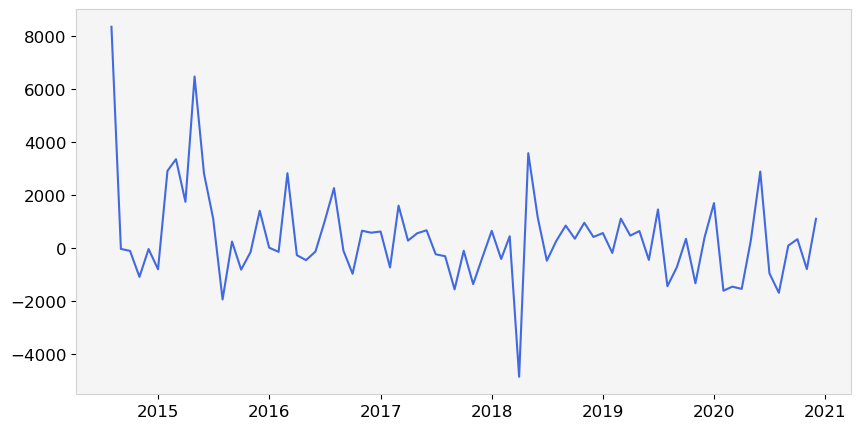

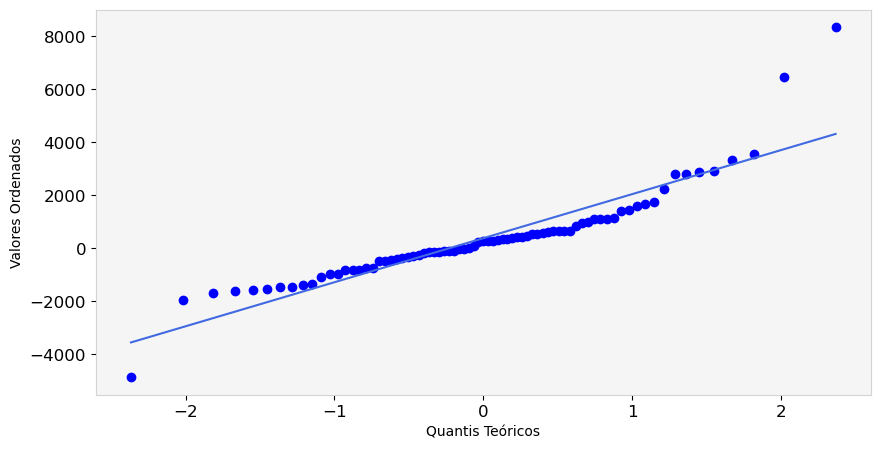

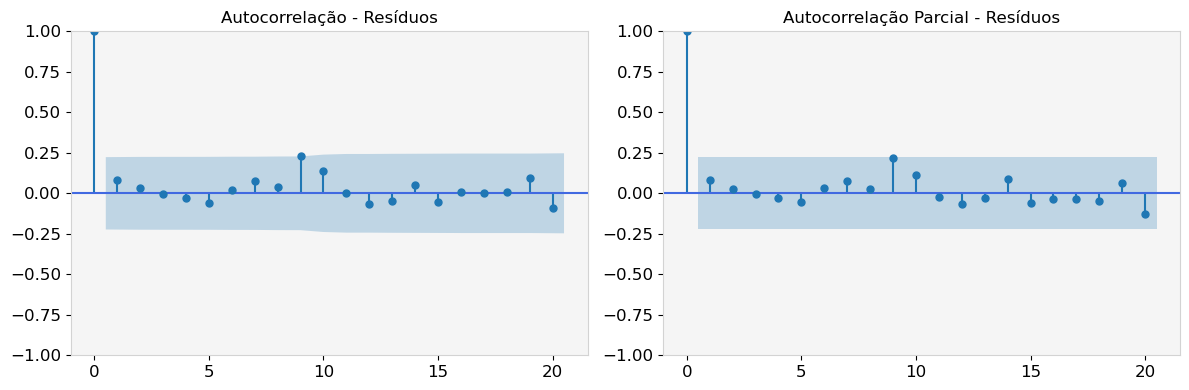

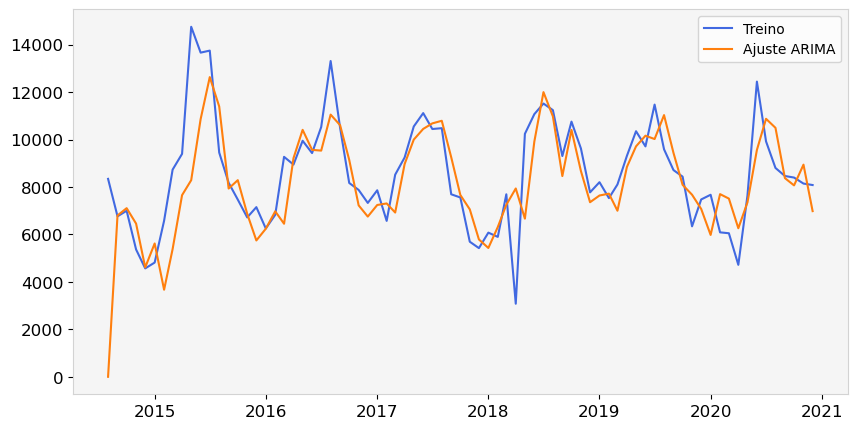

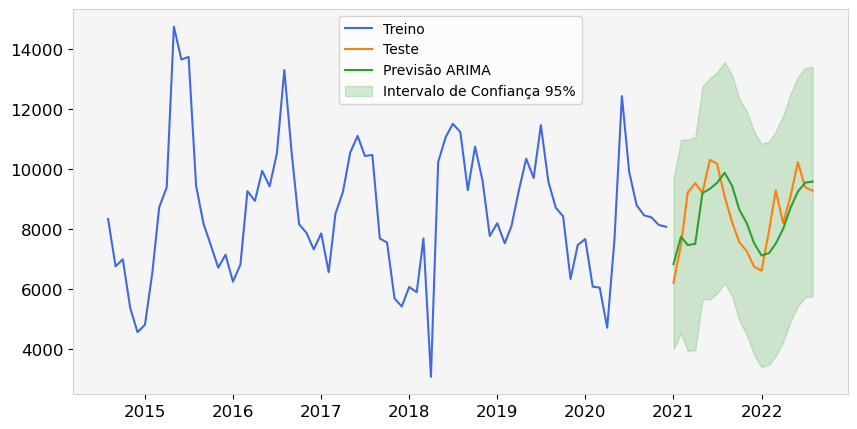

MAPE: 9.45%
RMSE: 973.54


In [45]:
fore_arima(6, 1, 6)

#### ARIMA(4, 0, 6)

AIC do Modelo ARIMA: 1350.0523110349197


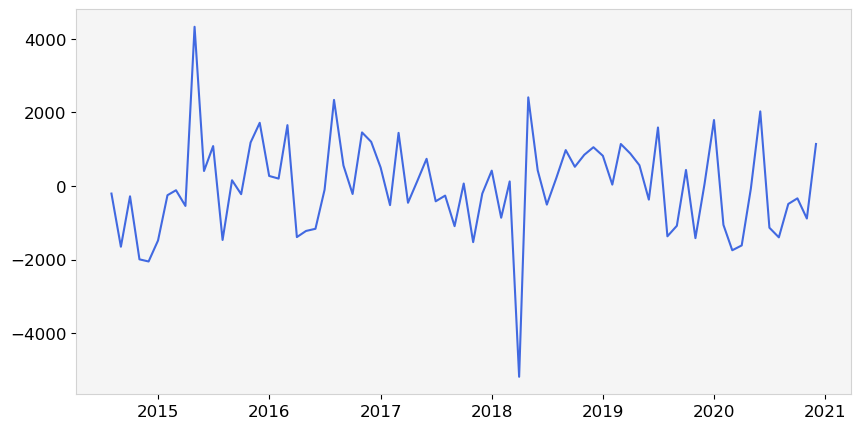

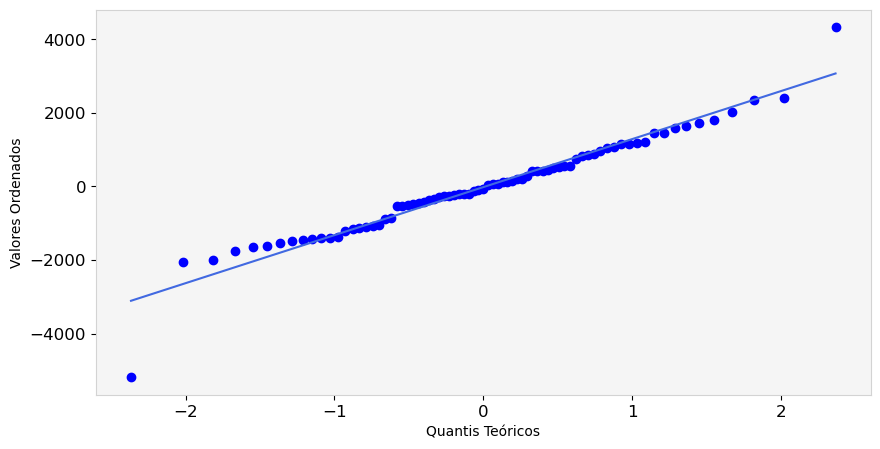

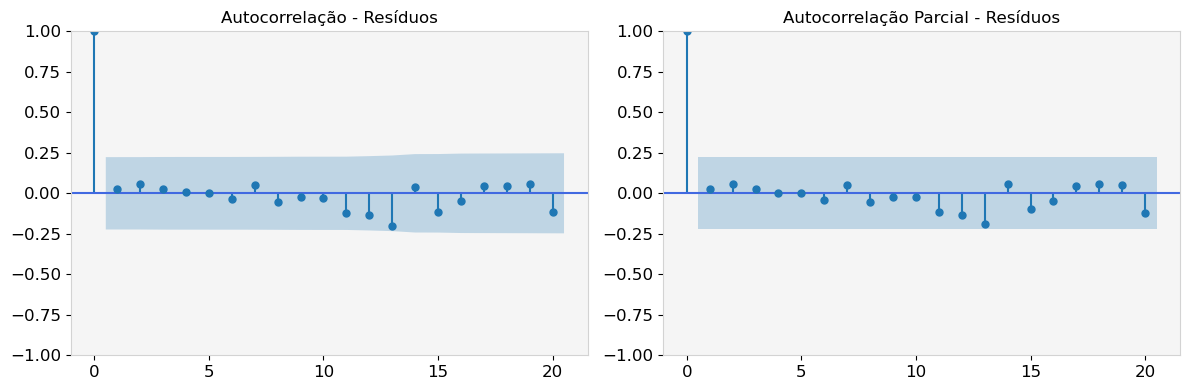

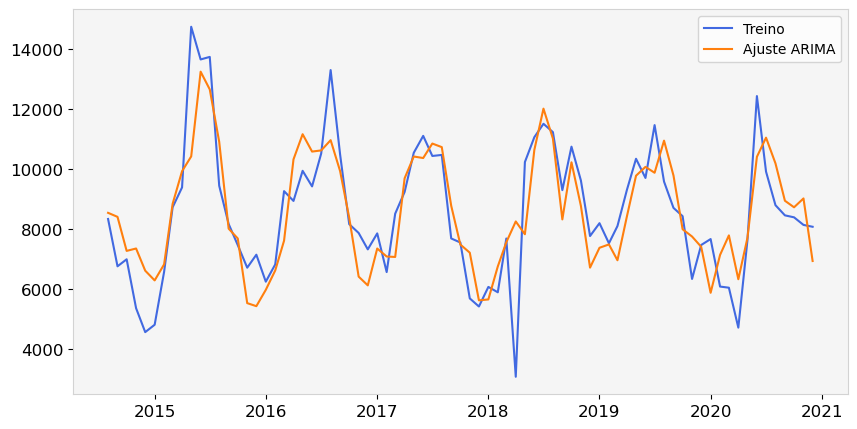

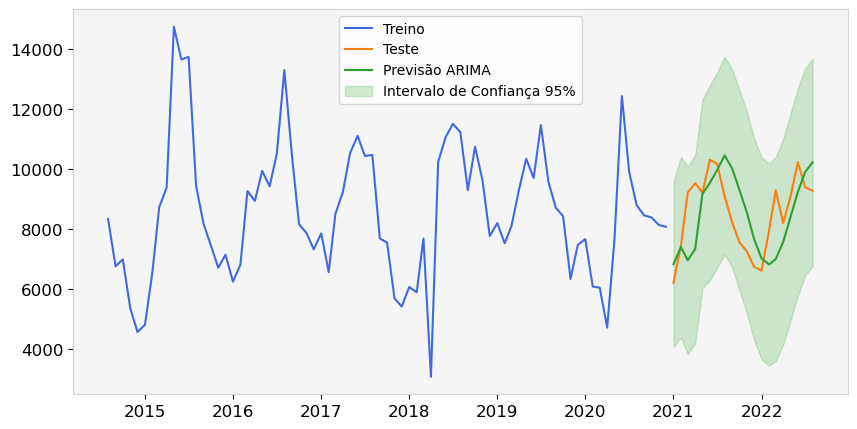

MAPE: 12.27%
RMSE: 1251.66


In [46]:
fore_arima(4, 0, 6)

#### 4. Previsão com Aprendizagem de Máquina (Random Florest)

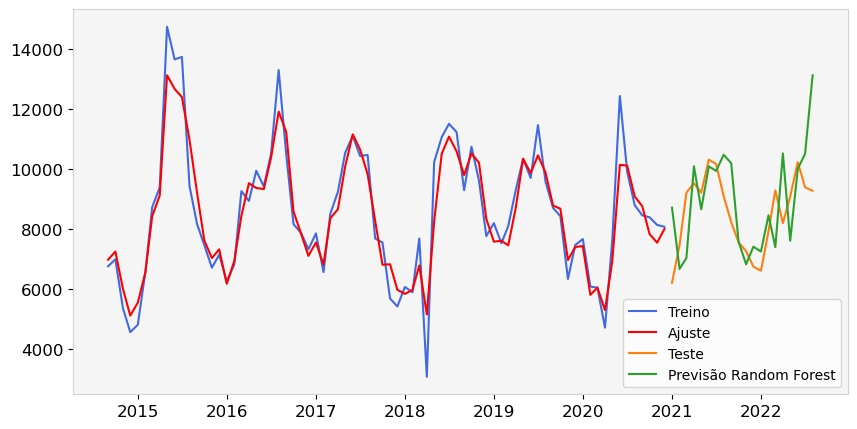

MAPE: 14.15%
RMSE: 1530.40


In [ ]:
# Carregar e ordenar dados
df_meses_v1 = df_meses_v1.sort_index()
data = df_meses_v1['qtdChamada']

# Preparação dos dados para o modelo Random Forest
df_lagged = pd.DataFrame(data)
# Criar uma coluna para o lag de 1 período
df_lagged['lag_1'] = df_lagged['qtdChamada'].shift(1)
df_lagged_period = eixo_train

# Remover valores nulos criados pelo lagging
df_lagged.dropna(inplace=True)

# Separação em treino e teste
train_size = int(len(df_lagged) * 0.8)
train, test = df_lagged[:train_size], df_lagged[train_size:]

X_train, y_train = train[['lag_1']], train['qtdChamada']
X_test, y_test = test[['lag_1']], test['qtdChamada']

# 3. Treinamento do modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)
y_pred_t = rf_model.predict(X_train)

# 5. Visualização das Previsões
fig, ax = plt.subplots(figsize=(10, 5))
plot_ax(eixo_train[1:], y_train, ax, "", "", "Treino")
plot_ax(eixo_train[1:], y_pred_t, ax, "", "#ff0000", "Ajuste")
plot_ax(eixo_test, y_test, ax, "", "#ff7f0e", "Teste")
plot_ax(eixo_test, y_pred, ax, "", '#2ca02c', 'Previsão Random Forest')
ax.legend()
plt.show()

# 6. Avaliação das Métricas de Previsão
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")


#### 5. Conclusão

A previsão de volume de chamadas em call centers é um tema fundamental para o dimensionamento de equipes dentro das operações, devido ao alto custo de manutenção de pessoas. Este trabalho explorou diferentes abordagens para a previsão, desde métodos estatísticos clássicos até a aplicação de técnicas de aprendizado de máquina, avaliando seus desempenhos em um estudo de caso real.

Ao trabalhar com modelagens ARIMA, a análise comparativa entre os modelos ARIMA (6,1,6) e (4,0,6) demonstra que, embora ambos apresentem bons resultados, a escolha do modelo ideal depende bastante do objetivo da previsão. O modelo ARIMA(6,1,6) apresentou um desempenho superior em termos de precisão, com valores 2,82 p.p. melhores para o MAPE e 28,6% melhores no RMSE, enquanto o modelo ARIMA (4,0,6) se destacou em termos de ajuste geral aos dados, com o AIC apresentando uma vantagem sutil, mas que contribuiu significativamente para um ajuste no período inicial da série.

A modelagem de aprendizado de máquina, utilizando Random Forest, mostrou-se eficiente em capturar padrões complexos da série temporal e obter uma precisão satisfatória, especialmente em cenários com maior variabilidade nos dados. Ao comparar com o melhor modelo ARIMA, o M1, os resultados apresentaram uma performance inferior de 4,7 p.p. para o MAPE e 57,2% no RMSE; em termos relativos, o MAPE foi de 9,6% para a modelagem clássica, enquanto para o Random Forest foi de 14,2%. Para o RMSE, foi de 973,5 na modelagem clássica e 1530,4 para o Random Forest.

De maneira geral, os resultados obtidos elucidaram que é possível desenvolver uma previsão univariada satisfatória do volume de chamadas em call centers, embora, ainda existam possibilidades de melhoria dos modelos, principalmente no que tange à captura de alguns padrões aleatórios, que não foram bem ajustados em ambas as modelagens.

Por fim, identificou-se a oportunidade de realizar estudos incorporando outras variáveis às previsões, como tempo de ligação, taxa de abandono, informações específicas do dia da semana e a análise de cenários com diferentes granularidades temporais, incluindo semanal e diária, além da abordagem mensal já utilizada. Além disso, podem ser incluídas outras abordagens clássicas e de aprendizado de máquina não aplicadas no estudo prático, e modelagens de aprendizado profundo, bem como a realização de testes aplicados a séries temporais em diferentes bases de dados e segmentos.

